# 1D Gaussian DSM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


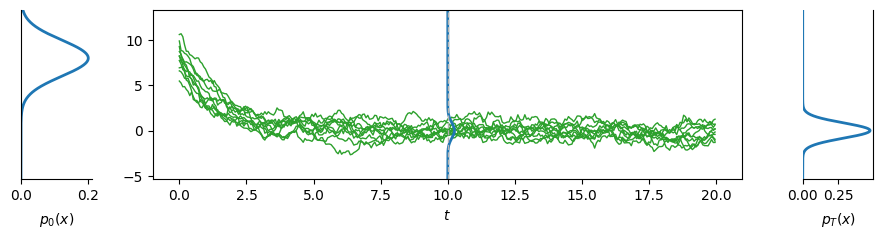

In [ ]:
import Final_1DGaussian_SDEODE_ForeBaxk as ou
from Final_1DGaussian_SDEODE_ForeBaxk import *

beta=0.7
sigma=1.0
T=20.0
t_target=10.0
dt=5e-3  #時間步長

mu1=8.0
s1=2.0

K_traj=10  #trajectories 數量
N_part=6000 #估計pdf形狀的OU粒子數

seed=0
rng = np.random.default_rng(seed)

# 測試檔案內function可用
SDE_forward(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part)

# DSM Loss
**Notation**

- $x_0$: original data;
- $p_0(x_0)$: data distribution of original data;
- $x$: noisy data (by perturbing the original data);
- $p(x \mid x_0)$: conditional (noisy) data distribution;
- $p_\sigma(x)$: (noisy) data distribution.

We also note that  
$$
p_\sigma(x) = \int_{\mathbb{R}^d} p(x \mid x_0)\, p_0(x_0)\, dx_0.
$$

The goal of denoising score matching is to find the **noisy score function**  
$$
S_\sigma(x; \theta) = \nabla_x \log p_\sigma(x).
$$

The DSM objective can be written as  
$$
L_{\text{DSM}}(\theta)
= \mathbb{E}_{x_0 \sim p_0(x_0)} \mathbb{E}_{x \sim p(x \mid x_0)}
\left[ \left\|\, S_\sigma(x; \theta) - \nabla_x \log p(x \mid x_0)\, \right\|^2 \right].
$$



一般來說在實務上會用Gaussian 作為data，也就是讓$x=x_0+\sigma\epsilon,\,\,\epsilon\sim\mathcal{N}(0,I)$。所以：
$$
\nabla_x \log p_\sigma(x|x_0)=-\frac{1}{\sigma^2}(x-x_0)=-\frac{1}{\sigma^2}\epsilon_{\sigma}.
$$
換言之，DSM的loss就可以被改寫為：
$$
L_{DSM}(\theta)= \mathbb{E}_{x_0\sim p_0(x_0)}\mathbb{E}_{x|x_0\sim p_\sigma(x|x_0)}\frac{1}{\sigma^2}\left\|\sigma S_\sigma(x_0+\sigma\epsilon;\theta)+\epsilon \right\|^2.
$$


## DSM code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cpu")
## ---參數跟之前差不多
beta=0.7
sigma=1.0   ## OU SDE's noise level
T=20.0
t_target=10.0
dt=5e-3  #時間步長

mu1=8.0
s1=2.0

K_traj=10  #trajectories 數量
N_part=6000 #估計pdf形狀的OU粒子數

seed=0
rng = np.random.default_rng(seed)

In [6]:
## 解析mean/var
def mean_t(t):
    return np.exp(-beta*t)*mu1
def var_t(t):
    return np.exp(-2*beta*t)*(s1**2)+(sigma**2/(2*beta))*(1-np.exp(-2*beta*t))
def true_score_np(x,t):
    m=mean_t(t)
    v=var_t(t)
    return -(x-m)/v

In [7]:
# 抽sample 用OU dataset 每次抽一個batch 的(x_t,t)
def sample_xt_t(batch_size):
    # t~uniform(0,T)
    t=np.random.uniform(0.0, T, size=(batch_size,1))
    m=mean_t(t)
    v=var_t(t)
    x=m+np.sqrt(v)*np.random.randn(batch_size,1)
    return x.astype(np.float32), t.astype(np.float32)  #順便規範浮點數


### 定義Score network : $S_\sigma(x; \theta)$

In [15]:
class ScoreNet(nn.Module):
    def __init__(self,hidden, num_layers):
        super().__init__()
        layers =[]
        in_dim =2
        h = hidden
        layers.append(nn.Linear(in_dim, h))
        layers.append(nn.SiLU())
        for _ in range(num_layers-1):  #num_layers-1 層
            layers.append(nn.Linear(h,h))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(h,1))
        self.net = nn.Sequential(*layers)

    def forward(self,x,t):
        z=torch.cat([x,t], dim=1)
        return self.net(z)

model=ScoreNet(hidden=128, num_layers=9).to(device)
#print(model)

### DSM loss + Training loop
**Goal:**
$$
S_{\sigma}(x;\theta)\approx-\frac{\epsilon}{\sigma_{dsm}}
$$

In [16]:
sigma_dsm=0.5
batch_size=512
num_steps=5000
lr=5e-3
optimizer=optim.Adam(model.parameters(), lr=lr)

def dsm_loss_step():
    # 1) sample(x_t,t) from true OU
    x_np, t_np = sample_xt_t(batch_size)
    x=torch.from_numpy(x_np).to (device)   #####<<<<<<<<<看一下為甚麼要那麼複雜
    t=torch.from_numpy(t_np).to (device)
    
    # 2) add DSM noise
    eps=torch.randn_like(x)
    x_tilde=x+sigma_dsm*eps

    # 3) predict score at noisy input
    s_hat=model(x_tilde,t)  ##(B,1)

    # 4) DSM target
    target = -eps / sigma_dsm
    loss=((s_hat-target)**2).mean()

    return loss

loss_history=[]
for step in range(1,num_steps+1):  ##從1到num_step的數值
    model.train()
    loss = dsm_loss_step()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if step%100==0:  ### 每100步寫一個
        print(f"step {step:5d} | loss = {loss.item():6f}")



step   100 | loss = 3.449921
step   200 | loss = 3.236906
step   300 | loss = 3.239840
step   400 | loss = 2.853776
step   500 | loss = 3.095230
step   600 | loss = 3.160238
step   700 | loss = 3.359187
step   800 | loss = 3.054452
step   900 | loss = 3.046358
step  1000 | loss = 2.807420
step  1100 | loss = 3.228085
step  1200 | loss = 3.017759
step  1300 | loss = 2.924906
step  1400 | loss = 3.128314
step  1500 | loss = 2.896647
step  1600 | loss = 3.046263
step  1700 | loss = 3.168319
step  1800 | loss = 3.140440
step  1900 | loss = 2.952132
step  2000 | loss = 3.041036
step  2100 | loss = 3.242256
step  2200 | loss = 2.995677
step  2300 | loss = 3.341063
step  2400 | loss = 3.170274
step  2500 | loss = 3.304025
step  2600 | loss = 2.818835
step  2700 | loss = 3.088375
step  2800 | loss = 2.952323
step  2900 | loss = 2.794203
step  3000 | loss = 3.181518
step  3100 | loss = 3.001454
step  3200 | loss = 2.997631
step  3300 | loss = 3.041608
step  3400 | loss = 2.966928
step  3500 | l

KeyboardInterrupt: 